# Aeolus Level 2B product

## Aeolus scientific wind product

> Abstract: Access to level 2B product and its visualization

## Load packages, modules and extensions

In [1]:
%load_ext blackcellmagic
# enable following line for interactive visualization backend for matplotlib
# %matplotlib widget
# print version info
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.22.0

viresclient: 0.9.1
pandas     : 1.2.4
xarray     : 0.17.0
matplotlib : 3.4.1



In [2]:
from viresclient import AeolusRequest
import numpy as np
from netCDF4 import num2date
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import matplotlib.cm as cm
import matplotlib.colors as colors
import cartopy.crs as ccrs

## Product information

The Level 2B wind product of the Aeolus mission is a geo-located consolidated HLOS (horizontal line-of-sight) wind observation with actual atmospheric correction and further bias corrections applied. The product is generated within 3 hours after data acquisition. 

Documentation:
-https://earth.esa.int/eogateway/catalog/aeolus-scientific-l2b-rayleigh-mie-wind-product

### L2B parameters on VirES

Many of the parameters of the L2B product can be obtained via the viresclient. A list of selected parameters can be found in the following table. For a complete list, please refer to the web client which lists the available parameters under the "Data" tab. For an explanation of the parameters, please refer to the VirES web client or the documentation (link above).
The parameters are available specifically for Rayleigh or Mie measurements and are then divided into Rayleigh-clear, Mie-cloudy, Rayleigh-cloudy and Mie-clear, the first two being the most reliable with the smallest errors according to their physical principle.
In contrast to the L1B-product, where whole measurement profiles are available, the L2B-product can be considered as point measurements where several profiles are averaged range bin-wise to obtain a "group". For each group, start and stop time as well as bottom and top altitude is avaiable as different parameters.  
A description of the parameters in the table is shown as tooltip when hovering the parameter name.

| Parameter | Rayleigh channel | Mie channel | Unit |
|:----------|:------------------------------:|:-------------------------:|:----:|
|[wind_result_start_time](## "Start date and time of the accumulation [UTC]")                   | x | x |   |
|[wind_result_stop_time](## "Stop date and time of the accumulation [UTC]")                     | x | x |   |
|[wind_result_COG_time](## "Center of gravity (CoG) date and time of the accumulation [UTC]")   | x | x |   |
|[wind_result_bottom_altitude](## "Bottom altitude for the accumulation]")                      | x | x | m |
|[wind_result_top_altitude](## "Top altitude for the accumulation")                             | x | x | m |
|[wind_result_COG_altitude](## "Vertical center of gravity altitude for the accumulation")      | x | x | m |
|[wind_result_id](## "An unique id for this wind in this L2B file")                             | x | x |   |
|[wind_result_range_bin_number](## "Range bin number this wind result belongs to")              | x | x |   |
|[wind_result_start_latitude](## "Start latitude for this accumulation")                        | x | x | 10<sup>-6</sup> DegN |
|[wind_result_stop_latitude](## "Stop latitude for this accumulation")                          | x | x | 10<sup>-6</sup> DegN |
|[wind_result_COG_latitude](## "CoG latitude for this accumulation")                            | x | x | 10<sup>-6</sup> DegN |
|[wind_result_start_longitude](## "Start longitude for this accumulation")                      | x | x | 10<sup>-6</sup> DegE |
|[wind_result_stop_longitude](## "Stop longitude for this accumulation")                        | x | x | 10<sup>-6</sup> DegE |
|[wind_result_COG_longitude](## "CoG longitude for this accumulation")                          | x | x | 10<sup>-6</sup> DegE |
|[wind_result_lat_of_DEM_intersection](## "Latitude of DEM intersection for the CoG of this accumulation")  | x | x | 10<sup>-6</sup> DegN |
|[wind_result_lon_of_DEM_intersection](## "Longitude of DEM intersection for the CoG of this accumulation") | x | x | 10<sup>-6</sup> DegE |
|[wind_result_alt_of_DEM_intersection](## "Altitude of DEM intersection for the CoG of this accumulation")  | x | x | m |
|[wind_result_geoid_separation](## "Height of geoid above WGS84 ellipsoid for each wind result")  | x | x | m |
|[wind_result_HLOS_error](## "Error estimate reported by the Mie processing algorithm")  | x | x | cm/s |
|[wind_result_reference_hlos](## "Reference HLOS wind taken from the matching profile in the AUX_MET file")  | x | x | cm/s |
|[wind_result_SNR](## "Signal to noise ratio of the Mie spectrum")  |   | x |  |
|[wind_result_scattering_ratio](## "Scattering ratio used to estimate the extinction (Mie-channel) or Mie signal for Mie decontamination (Rayleigh-channel) for this wind result")  | x | x |  |
|[wind_result_background_high](## "A value of 1 indicates that this data was taken during daylight")  | x | x |  |
|[wind_result_observation_type](## "Divides the observation conditions into undefined=0, cloudy=1, clear=2")  | x | x |  |
|[wind_result_validity_flag](## "Validity flag (1 or TRUE = valid, 0 or FALSE = invalid)")  | x | x |  |
|[wind_result_wind_velocity](## "Wind velocity given in cm/s and rounded to the nearest integer)")  | x | x | cm/s |
|[wind_result_integration_length](## "Horizontal integration length for the reported wind")  | x | x | m |
|[wind_result_num_of_measurements](## "Number of measurements used to construct the accumulation used to derive the wind result")  | x | x |  |
|[wind_result_albedo_off_nadir](## "Wind result albedo off nadir")  | x | x |  |
|[wind_result_reference_temperature](## "Reference temperature used for inverting the Rayleigh response into an HLOS wind")  | x |   | 10<sup>-2</sup>K |
|[wind_result_reference_pressure](## "Reference pressure used for inverting the Rayleigh response into an HLOS wind")  | x |   | Pa |


## Defining product, parameters and time for the data request
Keep in mind that the time for **one full orbit** is aorund **90 minutes**.
The **repeat cycle** of the orbits is **7 days**.

In [3]:
# Aeolus product
DATA_PRODUCT = "ALD_U_N_2B"

# measurement period in yyyy-mm-ddTHH:MM:SS
measurement_start = "2020-10-20T00:00:00Z"
measurement_stop = "2020-10-20T02:00:00Z"

### Define Rayleigh parameter

In [4]:
# Product parameters to retrieve
# uncomment parameters of interest

# Rayleigh wind fields
parameter_rayleigh = [
    "wind_result_start_time",
    "wind_result_stop_time",
    "wind_result_bottom_altitude",
    "wind_result_top_altitude",
    "wind_result_range_bin_number",
    "wind_result_start_latitude",
    "wind_result_start_longitude",
    "wind_result_stop_latitude",
    "wind_result_stop_longitude",
    "wind_result_COG_latitude",
    "wind_result_COG_longitude",
    "wind_result_HLOS_error",
    "wind_result_wind_velocity",
    "wind_result_observation_type",
    "wind_result_validity_flag",
]
parameter_rayleigh = ["rayleigh_" + param for param in parameter_rayleigh]

### Define Mie parameter

In [5]:
# Mie wind fields
parameter_mie = [
    "wind_result_start_time",
    "wind_result_stop_time",
    "wind_result_bottom_altitude",
    "wind_result_top_altitude",
    "wind_result_range_bin_number",
    "wind_result_start_latitude",
    "wind_result_start_longitude",
    "wind_result_stop_latitude",
    "wind_result_stop_longitude",
    "wind_result_COG_latitude",
    "wind_result_COG_longitude",
    "wind_result_HLOS_error",
    "wind_result_wind_velocity",
    "wind_result_observation_type",
    "wind_result_validity_flag",
]
parameter_mie = ["mie_" + param for param in parameter_mie]

## Retrieve data from VRE server

In [6]:
# Data request for Rayleigh wind measurements
# check if parameter list is not empty
if len(parameter_rayleigh) > 0:

    request = AeolusRequest()

    request.set_collection(DATA_PRODUCT)

    # set wind fields
    request.set_fields(
        rayleigh_wind_fields=parameter_rayleigh,
        # mie_wind_fields=parameter_mie,
    )

    # set start and end time and request data
    data_rayleigh = request.get_between(
        start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
    )

# Data request for Mie wind measurements
# check if parameter list is not empty
if len(parameter_mie) > 0:

    request = AeolusRequest()

    request.set_collection(DATA_PRODUCT)

    # set measurement fields
    request.set_fields(
        mie_wind_fields=parameter_mie,
    )

    # set start and end time and request data
    data_mie = request.get_between(
        start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
    )

# Save data as xarray data sets
# check if variable is assigned
if "data_rayleigh" in globals():
    ds_rayleigh = data_rayleigh.as_xarray()
if "data_mie" in globals():
    ds_mie = data_mie.as_xarray()

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (1.357MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (9.401MB)

## Plot overview map

Here all observation types (Rayleigh-clear, Rayleigh-cloudy, Mie-clear, Mie-cloudy) are plotted.

Text(0.5, 0.98, 'Aeolus orbit \n from 2020-10-20T00:00:00Z to 2020-10-20T02:00:00Z \n')

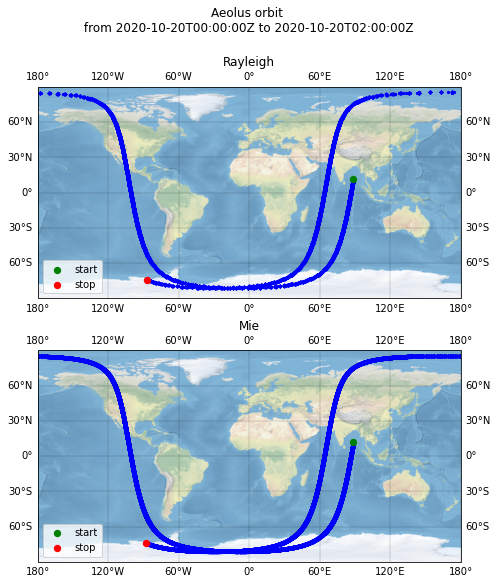

In [7]:
fig, ax = plt.subplots(
    2,
    1,
    figsize=(8, 8),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True,
)
for axis, ds, obs_type in zip(ax, [ds_rayleigh, ds_mie], ["rayleigh", "mie"]):
    axis.stock_img()
    gl = axis.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="-")
    axis.scatter(
        ds[obs_type + "_wind_result_COG_longitude"],
        ds[obs_type + "_wind_result_COG_latitude"],
        marker="o",
        c="b",
        s=5,
        transform=ccrs.Geodetic(),
    )
    axis.scatter(
        ds[obs_type + "_wind_result_COG_longitude"][0],
        ds[obs_type + "_wind_result_COG_latitude"][0],
        marker="o",
        c="g",
        edgecolor="g",
        s=40,
        label="start",
        transform=ccrs.Geodetic(),
    )
    axis.scatter(
        ds[obs_type + "_wind_result_COG_longitude"][-1],
        ds[obs_type + "_wind_result_COG_latitude"][-1],
        marker="o",
        c="r",
        edgecolor="r",
        s=40,
        label="stop",
        transform=ccrs.Geodetic(),
    )
    axis.legend()
    axis.set_title(obs_type.title())
fig.suptitle("Aeolus orbit \n from {} to {} \n".format(measurement_start, measurement_stop))

## Plot parameter

### Curtain plot
Define 2D plot function for L2B point-like measurements

In [8]:
def plot_parameter_2D(
    parameter="wind_result_wind_velocity",
    channel="rayleigh",
    obs_type="clear",
    QC_filter=True,
    error_estimate_threshold=800,
    start_bin=0,
    end_bin=-1,
):

    if channel == "rayleigh":
        ds = ds_rayleigh
    elif channel == "mie":
        ds = ds_mie

    # define necessary parameters for plotting
    X0 = ds[channel + "_wind_result_start_time"].values
    X1 = ds[channel + "_wind_result_stop_time"].values

    Y0 = ds[channel + "_wind_result_bottom_altitude"].values / 1000.0
    Y1 = ds[channel + "_wind_result_top_altitude"].values / 1000.0
    Z = ds[channel + "_" + parameter].values

    # create a mask out of different filters which can be applied to the different parameters
    mask = np.zeros(len(Z), dtype=bool)

    # mask dependent on start and end bing given as parameter to the plot function
    mask[0:start_bin] = True
    mask[end_bin:-1] = True

    # mask where validity flag is 0
    if QC_filter:
        mask = mask | (ds[channel + "_wind_result_validity_flag"] == 0)

    # mask dependent on observation type
    if obs_type == "cloudy":
        mask = mask | (ds[channel + "_wind_result_observation_type"] != 1)
    elif obs_type == "clear":
        mask = mask | (ds[channel + "_wind_result_observation_type"] != 2)

    # mask where wind results have error estimates larger than a given threshold
    mask = mask | (ds[channel + "_wind_result_HLOS_error"] > error_estimate_threshold)

    # mask all necessary parameters for plotting
    # tilde before mask inverts the mask
    X0 = X0[~mask]
    X1 = X1[~mask]
    Y0 = Y0[~mask]
    Y1 = Y1[~mask]
    Z = Z[~mask]

    patches = []
    for x0, x1, y0, y1 in zip(X0, X1, Y0, Y1):
        patches.append(((x0, y0), (x0, y1), (x1, y1), (x1, y0)))

    # define min and max value for the colorbar
    if parameter == "wind_result_wind_velocity":
        Z_vmax = np.amax(np.abs(np.asarray([np.nanpercentile(Z, 2), np.nanpercentile(Z, 98)])))
        Z_vmin = -Z_vmax
    else:
        Z_vmax = np.nanpercentile(Z, 99)
        Z_vmin = np.nanpercentile(Z, 1)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)
    coll = PolyCollection(
        patches,
        array=Z,
        cmap=cm.RdBu_r,
        norm=colors.Normalize(
            vmin=Z_vmin,
            vmax=Z_vmax,
            clip=False,
        ),
    )
    ax.add_collection(coll)

    # ax.set_ylim(-1, 30)
    ax.set_xlabel("Date [UTC]")
    ax.set_ylabel("Altitude [km]")
    ax.set_title("{} - {} \n {} wind results".format(channel.title(), parameter, len(Z)))
    ax.grid()

    def format_date(x, pos=None):
        dt_obj = num2date(x, units="s since 2000-01-01", only_use_cftime_datetimes=False)
        return dt_obj.strftime("%H:%M:%S")

    ax.xaxis.set_major_formatter(format_date)
    ax.autoscale()
    fig.colorbar(coll, ax=ax, aspect=50, pad=0.01)
    fig.autofmt_xdate()

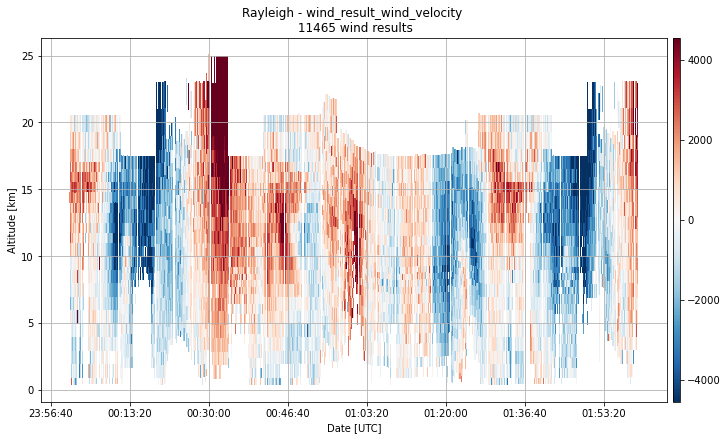

In [9]:
plot_parameter_2D(
    parameter="wind_result_wind_velocity",
    channel="rayleigh",
    obs_type="clear",
    QC_filter=True,
    error_estimate_threshold=800,
    start_bin=0,
    end_bin=-1,
)

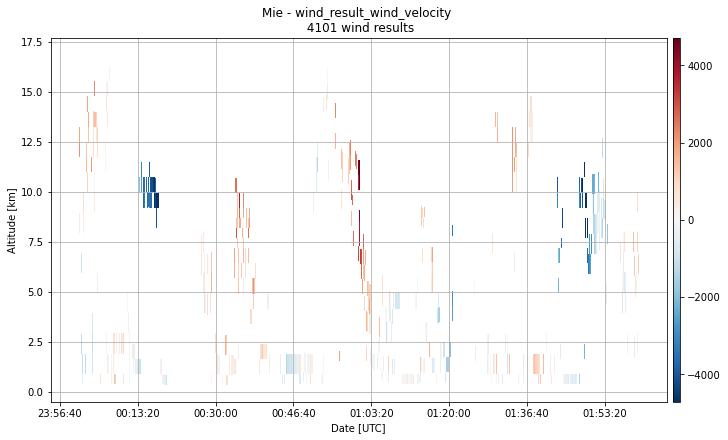

In [10]:
plot_parameter_2D(
    parameter="wind_result_wind_velocity",
    channel="mie",
    obs_type="cloudy",
    QC_filter=True,
    error_estimate_threshold=500,
    start_bin=0,
    end_bin=-1,
)